# Import libraries

In [119]:
%reset -f
# Mute warnings
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
from category_encoders import MEstimateEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow import keras
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_predict

To know more about the dataset: https://www.kaggle.com/competitions/spaceship-titanic/dataa

# Data preprocessing

In [120]:
def load_data():
    # Read data
    df_train = pd.read_csv(".//train.csv")
    df_test = pd.read_csv(".//test.csv")
    
    # Merge the splits so we can process them together
    df = pd.concat([df_train, df_test],ignore_index=True)
 
    # Preprocessing
    df = clean(df)
    df = impute(df)

    # Reform splits
    df_train = df[df.index<len(df_train)].reset_index(drop=True)
    df_test  = df[df.index >= len(df_train)].reset_index(drop=True)
    return df_train,df_test

## Cleaning data

In [121]:
def clean(df):
    df[["gggg", "pp"]] = (df["PassengerId"].str.split("_", expand=True))
    df["gggg"] = df["gggg"].str.replace('^0+', '').astype(int)
    df["pp"] = df["pp"].str.replace('^0+', '').astype(int)
    df = df.drop(columns=["PassengerId","Name"])
    df[["deck", "num","side"]] = (  df["Cabin"].str.split("/", expand=True,n=3))
    df = df.drop(columns="Cabin")
    return df

## Imputing data

In [122]:
def impute(df):
    cols_num = df.select_dtypes(include=np.number).columns.to_list()
    df[cols_num] = df[cols_num].fillna(0)
    df = df.fillna(df.mode().iloc[0])
    df["Transported"] = df["Transported"].astype(int)
    df["Age"] =  df["Age"].astype(int)
    return df

In [123]:
def label_encode(X):
    cols_cat = X.select_dtypes(exclude=np.number).columns.to_list()
    for col in cols_cat:
        X[col] = X[col].astype('category')
        X[col] = X[col].cat.codes
    return X

# Load data

In [124]:
df_train,df_test = load_data()

# Baseline

In [125]:
def score_dataset(X, y, model=RandomForestClassifier()):
    cols_cat = X.select_dtypes(exclude=np.number).columns.to_list()
    for col in cols_cat:
        X[col] = X[col].astype('category')
        X[col] = X[col].cat.codes
    
    score = cross_val_score(
        model, X, y, cv=5, scoring="accuracy",
    )
   
    return score

In [126]:
X = df_train.copy()
y = X.pop("Transported")

baseline_score = score_dataset(X, y)
baseline_score

array([0.65152386, 0.73893042, 0.79528465, 0.81588032, 0.74741082])

# Feature Engineering

## Mutual information

In [127]:
X = df_train.copy()
y = X.pop("Transported")
X = label_encode(X)
discrete_features = X.dtypes != float

In [128]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores  

gggg            0.512914
num             0.143284
CryoSleep       0.112254
Spa             0.074559
VRDeck          0.073867
RoomService     0.072730
ShoppingMall    0.051808
FoodCourt       0.048082
deck            0.022989
HomePlanet      0.018581
Age             0.013379
Destination     0.006113
side            0.005149
pp              0.004350
VIP             0.000700
Name: MI Scores, dtype: float64

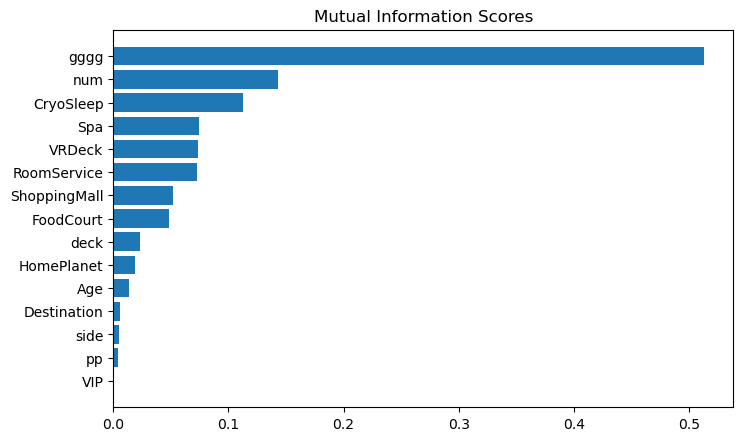

In [129]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

Check for uninformative features

In [130]:
def drop_uninformative(df, mi_scores,th=0):
    return df.loc[:, mi_scores > th]

In [131]:
X = df_train.copy()
y = X.pop("Transported")
X = drop_uninformative(X, mi_scores)

score_dataset(X, y)

array([0.54859114, 0.73375503, 0.79988499, 0.81588032, 0.74741082])

## Adding new features

In [132]:
X = df_train.copy()
y = X.pop("Transported")
X = drop_uninformative(X, mi_scores)
X["total_exp"] = X["RoomService"] + X["FoodCourt"] +X["ShoppingMall"]+X["Spa"]+X["VRDeck"]
score_dataset(X, y)


array([0.57676826, 0.73663025, 0.78838413, 0.81472957, 0.76294591])

We have improved peformances with our new feature

## Target encoding

Let's try target encoding for num 

In [133]:
X = df_train.copy()

# Encoding split
X_encode = X.sample(frac=0.20, random_state=0)
y_encode = X_encode.pop("Transported")

# Training split
X_pretrain = X.drop(X_encode.index)
y_train = X_pretrain.pop("Transported")

encoder = MEstimateEncoder(
    cols=["deck"],
    m=1.0,
)

# Fit the encoder on the encoding split
encoder.fit(X_encode, y_encode)

# Encode the training split
X_train = encoder.transform(X_pretrain, y_train)

Text(0.5, 0, 'Transported')

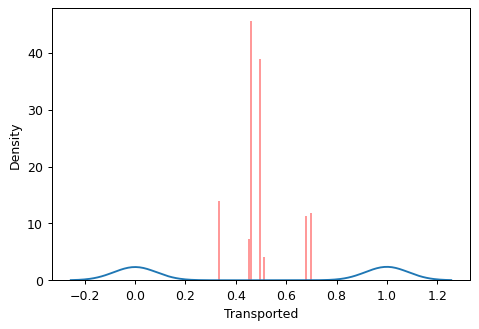

In [134]:
feature = encoder.cols
plt.figure(dpi=90)
ax = sns.distplot(y_train, kde=True, hist=False)
ax = sns.distplot(X_train[feature], color='r', ax=ax, hist=True, kde=False, norm_hist=True)
ax.set_xlabel("Transported")

In [135]:
X = df_train.copy()
y = X.pop("Transported")
score_base = score_dataset(X, y)
score_new = score_dataset(X_train, y_train)

print(score_base)
print(score_new)

[0.67625072 0.7360552  0.79930995 0.81242808 0.73590334]
[0.66786485 0.74982027 0.79007908 0.81308411 0.76618705]


In [136]:
print("Previous score: ",score_new)
X_train["total_exp"] = X_train["RoomService"] + X_train["FoodCourt"] +X_train["ShoppingMall"]+X_train["Spa"]+X_train["VRDeck"]
X_train["ExpDeck"] = X_train.groupby("deck")["total_exp"].transform("mean")
X_train["ExpSide"] = X_train.groupby("side")["total_exp"].transform("mean")
X_train["ExpHome"] = X_train.groupby("HomePlanet")["total_exp"].transform("mean")
X_train["ExpCryo"] = X_train.groupby("CryoSleep")["total_exp"].transform("mean")
X_train["ExpDest"] = X_train.groupby("Destination")["total_exp"].transform("mean")
X_train["ExpVip"] = X_train.groupby("VIP")["total_exp"].transform("mean")
print("Score_group: ",score_dataset(X_train,y_train))

Previous score:  [0.66786485 0.74982027 0.79007908 0.81308411 0.76618705]
Score_group:  [0.72393961 0.7620417  0.80301941 0.81092739 0.77769784]


In [137]:
X_train_norm = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
print("Score_group_norm",score_dataset(X_train_norm,y_train))

Score_group_norm [0.70237239 0.74838246 0.79654925 0.80805176 0.78920863]


## KMEANS

In [138]:

from sklearn.cluster import KMeans
def cluster_labels(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    #X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0)
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.fit_predict(X_scaled)
    return X_new

def cluster_distance(df, features, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    #X_scaled = (X_scaled - X_scaled.mean(axis=0)) / X_scaled.std(axis=0)
    kmeans = KMeans(n_clusters=20, n_init=50, random_state=0)
    X_cd = kmeans.fit_transform(X_scaled)
    # Label features and join to dataset
    X_cd = pd.DataFrame(
        X_cd, columns=[f"Centroid_{i}" for i in range(X_cd.shape[1])]
    )
    return X_cd

In [139]:
cluster_features = [
    "Age",
    "FoodCourt",
    "ShoppingMall",
    "Spa",
    "VRDeck",
    "total_exp"
]

In [140]:
X_train_norm = X_train_norm.reset_index(drop=True)
X_train_norm =  X_train_norm.join(cluster_labels(X_train_norm, cluster_features, n_clusters=10))
print("Score_group_norm_clust",score_dataset(X_train_norm,y_train))

Score_group_norm_clust [0.73112868 0.76635514 0.80014378 0.81380302 0.78848921]


## PCA

In [141]:

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

def pca_components(df, features):
    X = df.loc[:, features]
    _, X_pca, _ = apply_pca(X)
    return X_pca

In [142]:
pca_features = ['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'total_exp', 'ExpDeck', 'ExpSide', 'ExpHome', 'ExpCryo',
       'ExpDest', 'ExpVip']

array([<AxesSubplot:title={'center':'% Explained Variance'}, xlabel='Component'>,
       <AxesSubplot:title={'center':'% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

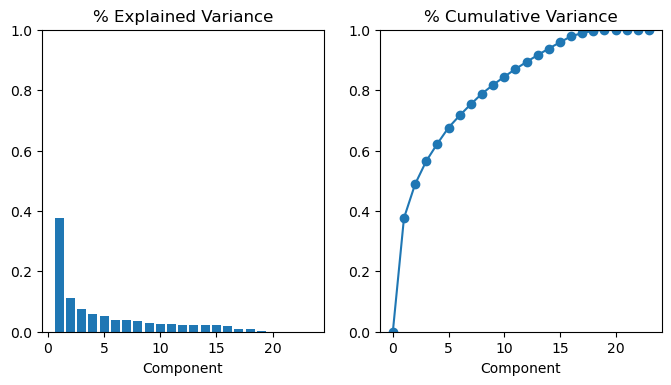

In [143]:
pca, X_pca, loadings = apply_pca(X_train_norm,standardize=False) #already normalized
plot_variance(pca)

In [144]:
X_train_norm = X_train_norm.join(pca_components(X_train_norm,features=pca_features))
print("Score_group_norm_clust_pca",score_dataset(X_train_norm,y_train))

Score_group_norm_clust_pca [0.74694464 0.76923077 0.79870597 0.8023005  0.80359712]


# Fine tuning

In [145]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1,scoring="accuracy")
rf_random.fit(X_train_norm, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.7s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   3.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  12.8s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  13.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000; total time=  15.6s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=2000

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, scoring='accuracy', verbose=2)

In [146]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 40,
 'bootstrap': True}

Best pam
{'n_estimators': 400,\
 'min_samples_split': 10,\
 'min_samples_leaf': 4,\
 'max_features': 'sqrt',\
 'max_depth': 90,\
 'bootstrap': True}

In [147]:
best_estimator = rf_random.best_estimator_

In [148]:
import joblib
my_model = best_estimator
joblib.dump(my_model, "my_best_estimator.pkl")
my_model_loaded = joblib.load("my_best_estimator.pkl")

In [149]:
preds = cross_val_predict(my_model_loaded,X_train_norm,y_train)
print("Best accuracy: ",np.sum(preds==y_train)/len(preds))

Best accuracy:  0.7883232671843543


# TF model

In [150]:
callback = keras.callbacks.EarlyStopping(monitor='val_accuracy',restore_best_weights = True,patience=10)

In [151]:
model = keras.Sequential([
    keras.layers.Input(shape=34),
    keras.layers.Dense(50,activation='relu'),
    keras.layers.Dense(50,activation='relu'),
    keras.layers.Dense(50,activation='relu'),
    keras.layers.Dense(50,activation='softmax')
])

model.compile(optimizer ='adam',loss=keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])
history = model.fit(X_train_norm,y_train,validation_split=0.1,verbose=True,epochs=50,callbacks=[callback])

2022-06-25 22:39:45.033662: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-25 22:39:45.034204: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


Train on 6258 samples, validate on 696 samples
Epoch 1/50
6258/6258 [==============================] - 1s 210us/sample - loss: 0.8835 - accuracy: 0.7039 - val_loss: 0.4874 - val_accuracy: 0.7572
Epoch 2/50
6258/6258 [==============================] - 1s 157us/sample - loss: 0.4280 - accuracy: 0.7897 - val_loss: 0.4542 - val_accuracy: 0.7744
Epoch 3/50
6258/6258 [==============================] - 1s 156us/sample - loss: 0.4142 - accuracy: 0.8012 - val_loss: 0.4745 - val_accuracy: 0.7601
Epoch 4/50
6258/6258 [==============================] - 1s 159us/sample - loss: 0.4049 - accuracy: 0.7975 - val_loss: 0.4431 - val_accuracy: 0.7845
Epoch 5/50
6258/6258 [==============================] - 1s 171us/sample - loss: 0.3985 - accuracy: 0.8038 - val_loss: 0.4718 - val_accuracy: 0.7672
Epoch 6/50
6258/6258 [==============================] - 1s 156us/sample - loss: 0.3905 - accuracy: 0.8129 - val_loss: 0.4981 - val_accuracy: 0.7615
Epoch 7/50
6258/6258 [==============================] - 1s 151us/

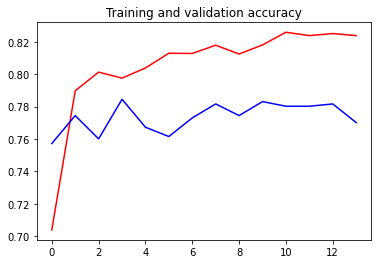

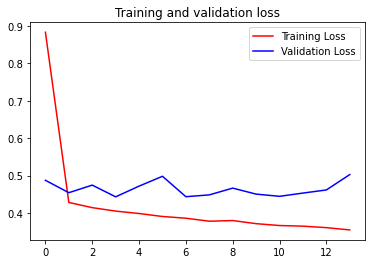

In [152]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
import matplotlib.pyplot as plt 
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Submission

In [153]:
id_test = pd.read_csv(".//test.csv")["PassengerId"]
X_test = df_test.drop(columns="Transported")

In [154]:
#targed encoding
X_test = encoder.transform(X_test)

#Adding new features
X_test["total_exp"] = X_test["RoomService"] + X_test["FoodCourt"] +X_test["ShoppingMall"]+X_test["Spa"]+X_test["VRDeck"]
X_test["ExpDeck"] = X_test.groupby("deck")["total_exp"].transform("mean")
X_test["ExpSide"] = X_test.groupby("side")["total_exp"].transform("mean")
X_test["ExpHome"] = X_test.groupby("HomePlanet")["total_exp"].transform("mean")
X_test["ExpCryo"] = X_test.groupby("CryoSleep")["total_exp"].transform("mean")
X_test["ExpDest"] = X_test.groupby("Destination")["total_exp"].transform("mean")
X_test["ExpVip"] = X_test.groupby("VIP")["total_exp"].transform("mean")

#Clustering
X_test = label_encode(X_test)
X_test = (X_test - X_test.mean(axis=0)) / X_test.std(axis=0)
X_test = X_test.join(cluster_labels(X_test, cluster_features, n_clusters=10))

#Pca analysis
X_test = X_test.join(pca_components(X_test,features=pca_features))

In [155]:
p = np.bool8(my_model_loaded.predict(X_test))
output = pd.DataFrame({'PassengerId': id_test, 'Transported': p})
output.to_csv('my_submission_.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
